In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

from autotroph_model import AutotrophModel, DEFAULT_ALPHA
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm, SymLogNorm, TwoSlopeNorm, BoundaryNorm
from pprint import pprint

In [2]:
mkdir -p ../figures/fig7

In [3]:
# Run the model with a fixed medium rubisco level gamma = 10 /s,
# varying CA (delta) and Ci uptake (chi) activities to explore growth and futile cycling.
# This model forms the basis of Fig. 7C and associated SI figures. 
# Note: we are intentionally using absurdly wide ranges for delta and chi in order 
# to see how the model behaves. 
my_deltas = np.logspace(-3, 4, 200)
my_chis = np.logspace(-3, 4, 200)
D, X = np.meshgrid(my_deltas, my_chis)

m = AutotrophModel(g=100, x=X, d=D)
Cleakage_mat = m.C_leakage()
Hleakage_mat = m.H_leakage()
biomass_mat = m.biomass_flux()
total_Ci_leakage = (Cleakage_mat + Hleakage_mat)
futile_mat = total_Ci_leakage / biomass_mat
Hin_mat = m.H_in()
Cin_mat = m.C_in()
hcarb_mat = m.hcarb_flux()
rub_mat = m.rubisco_flux()

FileNotFoundError: [Errno 2] No such file or directory: '../figures/sup_figs_model/fig7_s2_fixed_rub_variable_delta_chi.png'

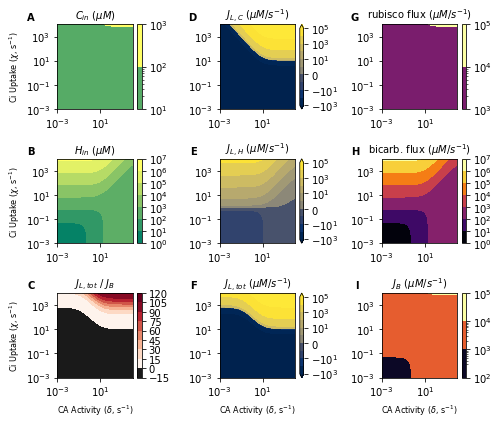

In [4]:
fig, axs = plt.subplots(ncols=3, nrows=3, figsize=(7,6))

titles = ['$C_{in}$ ($\mu M$)', '$H_{in}$ ($\mu M$)']
mats = [Cin_mat, Hin_mat]
for mat, title, ax in zip(mats, titles, axs[:,0]):
    plt.sca(ax)
    plt.yscale('log')
    plt.xscale('log')
    plt.title(title, fontsize=10)

    my_norm = LogNorm(mat.min(), mat.max())
    plt.contourf(my_deltas, my_chis, mat, cmap='summer',
                 norm=my_norm)
    plt.colorbar()

titles = ['$J_{L,C}$ ($\mu M / s^{-1}$)', '$J_{L,H}$ ($\mu M / s^{-1}$)', '$J_{L,tot}$ ($\mu M / s^{-1}$)']
mats = [Cleakage_mat, Hleakage_mat, total_Ci_leakage]
for mat, title, ax in zip(mats, titles, axs[:,1]):
    plt.sca(ax)
    plt.yscale('log')
    plt.xscale('log')
    plt.title(title, fontsize=10)

    vmin = -1e3
    vmax = 1e5
    log10vmin = int(np.floor(np.log10(-vmin)))
    log10vmax = int(np.floor(np.log10(vmax)))
    levels = (-np.logspace(0, log10vmin, log10vmin+1)).tolist()[::-1]
    levels += [0] + np.logspace(0, log10vmax, log10vmax+1).tolist()

    my_norm = SymLogNorm(0.1, vmin=vmin, vmax=vmax)
    plt.contourf(my_deltas, my_chis, mat, cmap='cividis',
                 norm=my_norm, extend='both', levels=levels)
    plt.colorbar()
    
titles = ['rubisco flux ($\mu M / s^{-1}$)', 'bicarb. flux ($\mu M / s^{-1}$)', '$J_B$ ($\mu M / s^{-1}$)']
mats = [rub_mat, hcarb_mat, biomass_mat]
for mat, title, ax in zip(mats, titles, axs[:,2]):
    plt.sca(ax)
    plt.yscale('log')
    plt.xscale('log')
    plt.title(title, fontsize=10)

    my_norm = LogNorm(vmin=mat.min(), vmax=mat.max())
    plt.contourf(my_deltas, my_chis, mat, cmap='inferno',
                 norm=my_norm)
    plt.colorbar()

plt.sca(axs[2,0])
plt.xscale('log')
plt.yscale('log')
plt.title('$J_{L,tot}$ / $J_B$', fontsize=10)

mat = futile_mat
my_norm = TwoSlopeNorm(0, vmin=mat.min(), vmax=mat.max())
plt.contourf(my_deltas, my_chis, futile_mat, norm=my_norm,
             cmap='RdGy_r')
plt.colorbar()

labels = 'ABCDEFGHI'
for i in np.arange(3):
    for j in np.arange(3):
        my_ax = axs[i, j]
        plt.sca(my_ax)
        plabel = labels[i+(j*3)]
        my_ax.text(-0.3, 1.15, plabel, transform=my_ax.transAxes,
             fontsize=10, fontweight='bold', va='top', ha='right')
        
        if i == 2:
            plt.xlabel('CA Activity ($\delta$, s$^{-1}$)', fontsize=8)
        if j == 0:
            plt.ylabel('Ci Uptake ($\chi$, s$^{-1}$)', fontsize=8)
            
plt.tight_layout()
plt.savefig('../figures/fig7/fig7_s2_fixed_rub_variable_delta_chi.png', dpi=600, facecolor='w')
plt.show()


In [ ]:
##### Futile cycle ambient zoom in.
# Need to figure out colors & placement for main text.
fig, axs = plt.subplots(figsize=(5.5,2.5), ncols=2, gridspec_kw=dict(width_ratios=[1,1.2]))
    
# Right axis - model
plt.sca(axs[0])

# Consider a full range of CA rates/concentrations
deltas = np.logspace(-2,4,100)

# The biomass flux can't be higher than the rubisco flux of
# a reference model with the maximum rubisco kinetics considered (100 /s)
ref_am = AutotrophModel(d=deltas, g=1e2)
max_biomass_flux = np.max(ref_am.rubisco_flux())

pal = ['greyish', 'dull orange', 'orange', 'rust', 'maroon']
pal = sns.xkcd_palette(pal)
models = [AutotrophModel(d=deltas, g=my_g) for my_g in np.logspace(0,2,5)]

for idx, am in enumerate(models):
    plt.loglog(deltas, am.growth_rate_hr(), c=pal[idx])
    
plt.ylabel('Growth Rate (hr$^{-1}$)', fontsize=9)
plt.xlabel('CA Activity (s$^{-1}$)', fontsize=9)

plt.sca(axs[1])
plt.yscale('log')
plt.xscale('log')
    
my_norm = TwoSlopeNorm(0, futile_mat.min(), futile_mat.max())
plt.contourf(my_deltas, my_chis, futile_mat, norm=my_norm, cmap='RdGy_r', alpha=0.6)
cb = plt.colorbar()
cb.set_label(label='leakage / biomass flux', size=9)

plt.xlabel('CA Activity (s$^{-1}$)', fontsize=9)
plt.ylabel('Ci Uptake (s$^{-1}$)', fontsize=9)

plt.tight_layout()
plt.savefig('../figures/fig7/fig7.png', dpi=600, facecolor='w')
plt.show()

In [ ]:
# Like the main text figure with variation in CI uptake too
fig, axs = plt.subplots(ncols=3, figsize=(7, 3))
plt.sca(axs[0])

pal = ['greyish', 'dull orange', 'orange', 'rust', 'maroon']
pal = sns.xkcd_palette(pal)

# Consider a full range of CA rates/concentrations
deltas = np.logspace(-2,4,200)

# The biomass flux can't be higher than the rubisco flux of
# a reference model with the maximum rubisco kinetics considered (100 /s)

models = [AutotrophModel(d=deltas, g=my_g) for my_g in np.logspace(0,2,5)]
for idx, am in enumerate(models):
    plt.loglog(deltas, am.growth_rate_hr(), c=pal[idx])
    
plt.title('Varying CA', fontsize=10)
plt.ylabel('Growth Rate (hr$^{-1}$)', fontsize=10)
plt.xlabel('CA Activity ($\delta$, s$^{-1}$)', fontsize=10)

# Consider a full range of Ci uptake rates
plt.sca(axs[1])
chis = np.logspace(-3,4,200)

models = [AutotrophModel(x=chis, g=my_g) for my_g in np.logspace(0,2,5)]
for idx, am in enumerate(models):
    plt.loglog(chis, am.growth_rate_hr(), c=pal[idx])

plt.title('Varying Ci Uptake', fontsize=10)
plt.xlabel('Ci Uptake ($\chi$, s$^{-1}$)', fontsize=10)

# Consider a full range of Ci uptake rates
plt.sca(axs[2])
c_exts = np.logspace(0,4,200)

pal = ['greyish', 'dull orange', 'orange', 'rust', 'maroon']
pal = sns.xkcd_palette(pal)
models = [AutotrophModel(c_out=c_exts, g=my_g) for my_g in np.logspace(0,2,5)]

for idx, am in enumerate(models):
    plt.loglog(c_exts, am.growth_rate_hr(), c=pal[idx])
    
null_model = AutotrophModel(c_out=c_exts, g=100, d=10)
plt.loglog(c_exts, null_model.growth_rate_hr(), c=pal[-1], ls='--')

plt.title('Varying External CO$_{2}$', fontsize=10)
plt.xlabel('External CO$_2$ ($\mu$M))', fontsize=10)

for plabel, ax in zip('ABC', axs):
    ax.text(-0.3, 1.15, plabel, transform=ax.transAxes,
             fontsize=10, fontweight='bold', va='top', ha='right')

plt.tight_layout()
plt.savefig('../figures/fig7/fig7_s2_CA_Ci_CO2_effects.png', facecolor='w', dpi=600)
plt.show()

In [ ]:
my_deltas = np.logspace(-3, 4, 200)
my_gammas = np.logspace(-2, 4, 200)
D, G = np.meshgrid(my_deltas, my_gammas)

fig, axs = plt.subplots(figsize=(7,5), ncols=3, nrows=2, gridspec_kw=dict(width_ratios=[1,1,1.2]))

# Model with "normal" CO2 permeability as typically measured/estimated
m = AutotrophModel(g=G, d=D, a=DEFAULT_ALPHA)
rubisco_mat = m.rubisco_flux()
bicarbox_mat = m.hcarb_flux()
biomass_mat = m.biomass_flux()
my_norm = LogNorm(0.1, 1e5)

mats = [rubisco_mat, bicarbox_mat, biomass_mat]
titles = ['rubisco flux ($\mu M / s^{-1}$)', 
          'bicarbox. flux ($\mu M / s^{-1}$)',
          '$J_B$ ($\mu M / s^{-1}$)']
for i, (mat, title) in enumerate(zip(mats, titles)):
    plt.sca(axs[0,i])
    plt.xscale('log')
    plt.yscale('log')
    plt.title(title, fontsize=10)
    plt.contourf(my_deltas, my_gammas, mat, norm=my_norm, cmap='inferno')
    
    if i == 0:
        plt.ylabel('Rubisco Activity ($\gamma$, s$^{-1}$)', fontsize=9)
    if i+1 == len(mats):
        plt.colorbar()
        
# Model with very low CO2 permeability and high Ci uptake
m = AutotrophModel(g=G, d=D, a=(1e-2*DEFAULT_ALPHA), x=100)
rubisco_mat = m.rubisco_flux()
bicarbox_mat = m.hcarb_flux()
biomass_mat = m.biomass_flux()
my_norm = LogNorm(1e-2, 1e4)
mats = [rubisco_mat, bicarbox_mat, biomass_mat]

for i, (mat, title) in enumerate(zip(mats, titles)):
    plt.sca(axs[1,i])
    plt.xscale('log')
    plt.yscale('log')
    plt.title(title, fontsize=10)
    plt.contourf(my_deltas, my_gammas, mat, norm=my_norm, cmap='cividis')
    
    plt.xlabel('CA Activity ($\delta$, s$^{-1}$)', fontsize=9)
    if i == 0:
        plt.ylabel('Rubisco Activity ($\gamma$, s$^{-1}$)', fontsize=9)
    if i+1 == len(mats):
        plt.colorbar()


for plabel, ax in zip('ABCDEF', axs.flatten()):
    ax.text(-0.3, 1.15, plabel, transform=ax.transAxes,
             fontsize=10, fontweight='bold', va='top', ha='right')

plt.tight_layout()
plt.savefig('../figures/fig7/fig7_s3_model_regimes.png', dpi=600, facecolor='w')
plt.show()